## Final Project Submission

Please fill out:
* Student name: Steven Rosa
* Student pace: part time
* Scheduled project review date/time: 
* Instructor name: Jeff Herman
* Blog post URL:


### Work flows
#### Parrish
https://gist.github.com/aparrish/2f562e3737544cf29aaf1af30362f469

#### Graph convolutional network ("semi-supervised")
https://towardsdatascience.com/text-based-graph-convolutional-network-for-semi-supervised-bible-book-classification-c71f6f61ff0f

In [1]:
url = 'https://www.gutenberg.org/ebooks/4217'

import copy
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #For viewing 3d pca feature plots
import seaborn as sns

from sklearn.decomposition import PCA #For squashing word vector means
from sklearn.preprocessing import StandardScaler #For normalizing data

#Learn workflow
from nltk.corpus import stopwords
import string #for removing punctuation from text
from nltk import word_tokenize #Another way of tokenizing
from nltk import FreqDist

from pandasql import sqldf #for manipulating DataFrames with SQL style queries

#Parrish workflow
from numpy import dot #parrish
from numpy.linalg import norm #parrish
import en_core_web_md #parrish
import spacy #parrish 
from __future__ import unicode_literals #parrish

# Learn.co workflow 

In [ ]:
#Needed for first time use on each machine:
#import nltk
#nltk.download('stopwords')

In [2]:
stop_list = stopwords.words('english')

# It is generally a good idea to also remove punctuation

# Now we have a list that includes all english stopwords, as well as all punctuation
stop_list += list(string.punctuation)
stop_list += ['could', 'like', 'one', 'said', 'would', '\'s', '\'ll']
#https://learn.co/tracks/data-science-career-v1-1/module-4-advanced-machine-learning-deep-learning/section-37-foundations-of-natural-language-processing-nlp/feature-engineering-for-text-data#

#&c &c &c

In [3]:
#Read files (without nlp module)
with open('chapter1.txt', 'r', encoding = 'utf-8') as f1, \
    open('chapter2.txt', 'r', encoding = 'utf-8') as f2, \
    open('chapter3.txt', 'r', encoding = 'utf-8') as f3, \
    open('chapter4.txt', 'r', encoding = 'utf-8') as f4, \
    open('chapter5.txt', 'r', encoding = 'utf-8') as f5:
    ch1 = f1.read()
    ch2 = f2.read()
    ch3 = f3.read()
    ch4 = f4.read()
    ch5 = f5.read()

In [11]:
#tokenize all
tokens1 = word_tokenize(ch1)
tokens2 = word_tokenize(ch2)
tokens3 = word_tokenize(ch3)
tokens4 = word_tokenize(ch4)
tokens5 = word_tokenize(ch5)
all_tokens = [tokens1, tokens2, tokens3, tokens4, tokens5]
full_text = []
full_text = [full_text.extend(tokens) for tokens in all_tokens]

In [6]:
def stop(words):
    '''
    Parameters:
    words (list)
    '''
    stop_list = stopwords.words('english')
    stop_list += list(string.punctuation)
    stop_list += ['could', 'like', 'one', 'said', 'would', '\'s', '\'ll']
    
    stopped = [w.lower() for w in words if w.lower() not in stop_list]
    return stopped

In [10]:
stopped_ch1 = stop(tokens1)
stopped_ch1

['upon',
 'time',
 'good',
 'time',
 'moocow',
 'coming',
 'along',
 'road',
 'moocow',
 'coming',
 'along',
 'road',
 'met',
 'nicens',
 'little',
 'boy',
 'named',
 'baby',
 'tuckoo',
 '...',
 'father',
 'told',
 'story',
 'father',
 'looked',
 'glass',
 'hairy',
 'face',
 'baby',
 'tuckoo',
 'moocow',
 'came',
 'road',
 'betty',
 'byrne',
 'lived',
 'sold',
 'lemon',
 'platt',
 'wild',
 'rose',
 'blossoms',
 'little',
 'green',
 'place',
 'sang',
 'song',
 'song',
 'green',
 'wothe',
 'botheth',
 'wet',
 'bed',
 'first',
 'warm',
 'gets',
 'cold',
 'mother',
 'put',
 'oilsheet',
 'queer',
 'smell',
 'mother',
 'nicer',
 'smell',
 'father',
 'played',
 'piano',
 'sailor',
 'hornpipe',
 'dance',
 'danced',
 'tralala',
 'lala',
 'tralala',
 'tralaladdy',
 'tralala',
 'lala',
 'tralala',
 'lala',
 'uncle',
 'charles',
 'dante',
 'clapped',
 'older',
 'father',
 'mother',
 'uncle',
 'charles',
 'older',
 'dante',
 'dante',
 'two',
 'brushes',
 'press',
 'brush',
 'maroon',
 'velvet',
 'b

In [8]:
stopped_ch1

In [12]:
stopped = {'Chapter_' + str(i + 1): stop(tokens) \
                for i, tokens in enumerate(all_tokens)}
#Get list of all stopped words in corpus
all_stopped = []
for key, val in stopped.items():
    all_stopped.extend(val)
    
fds = {key: FreqDist(stopped[key]) for key, val in stopped.items()}
all_fd = FreqDist(all_stopped)

#Use frequency distributions from each column to construct 
#a DataFrame listing frequency of every word across every chapter
word_counts = pd.DataFrame(list(all_fd.items()), columns = ['Word','Total'])

for key, val in fds.items():
    word_counts[key] = [val[word] if val[word] else 0 \
                  for word in word_counts['Word']]

In [13]:
word_counts.head(10)

,Word,Total,Chapter_1,Chapter_2,Chapter_3,Chapter_4,Chapter_5
0,upon,121,6,19,46,17,33
1,time,118,19,13,41,11,34
2,good,91,14,21,21,5,30
3,moocow,3,3,0,0,0,0
4,coming,29,7,6,6,1,9
5,along,55,17,18,3,5,12
6,road,31,7,14,0,1,9
7,met,13,2,1,3,0,7
8,nicens,1,1,0,0,0,0
9,little,130,49,31,20,5,25


## Corpus statistics

In [5]:
#Get counts for every token in each chapter
def word_counts_table(df, column):
    '''
    '''
    q = ''' SELECT *
            FROM {} df
            ORDER BY df.{} DESC
    ;'''.format(df, column)
    results = pysqldf(q)
    print(q)
    return results

def word_percents_table(df, chapters, order_by):
    '''
    Parameters:
    chapters (list) list(fds.keys())
    '''
    #Solve fence post comma problem by building different string if key is last in list
    select = ''.join(['''(df.''' + key + ' * 1000 / df.Total) * 0.1 ' + key + ''', 
        ''' if key != chapters[-1] else \
        '(df.' + key + ' * 1000 / df.Total) * 0.1 ' + key + ''' 
        ''' for key in chapters])
    
    q = '''SELECT df.Word, df.Total, 
        '''
    q += select
    q += '''
        FROM {} df
        ;'''.format(df, order_by)
    results = pysqldf(q)
    print(q)
    return results

def select_percent_lim(df, percent, lim, chapters):
    '''
    
    '''
    select = ''.join([
        'SUM(CASE WHEN df.' + key + ' > ' + str(percent) + \
        ' AND df.Total > ' + str(lim) + \
        ' THEN 1 ELSE 0 END) ' + key + ''', 
        ''' if key != chapters[-1] else \
        'SUM(CASE WHEN df.' + key + ' > ' + str(percent) + \
        ' AND df.Total > ' + str(lim) + \
        ' THEN 1 ELSE 0 END) '  + key + ''' 
        ''' for key in chapters])
    q = 'SELECT '
    q += select
    q += '''FROM {} df
    ;'''.format(df)
    results = pysqldf(q)
    print(q)
    return results

In [14]:
#A lambda function with the "globals" so I don't have to pass them in every time
pysqldf = lambda q: sqldf(q, globals())

In [65]:
word_counts_ordered = word_counts_table('word_counts', 'Chapter_5')

 SELECT *
            FROM word_counts df
            ORDER BY df.Chapter_5 DESC
    ;


In [66]:
word_counts_ordered.head(10)

,Word,Total,Chapter_1,Chapter_2,Chapter_3,Chapter_4,Chapter_5
0,stephen,433,72,99,11,22,229
1,cranly,140,0,0,0,0,140
2,eyes,173,40,25,28,20,60
3,temple,60,0,0,1,0,59
4,asked,104,26,11,4,5,58
5,mind,108,2,18,17,18,53
6,first,122,25,15,17,13,52
7,lynch,51,0,0,0,0,51
8,know,103,25,12,11,6,49
9,man,106,11,25,20,7,43


In [15]:
percents = word_percents_table('word_counts', list(fds.keys()), 'Chapter_1')

SELECT df.Word, df.Total, 
        (df.Chapter_1 * 1000 / df.Total) * 0.1 Chapter_1, 
        (df.Chapter_2 * 1000 / df.Total) * 0.1 Chapter_2, 
        (df.Chapter_3 * 1000 / df.Total) * 0.1 Chapter_3, 
        (df.Chapter_4 * 1000 / df.Total) * 0.1 Chapter_4, 
        (df.Chapter_5 * 1000 / df.Total) * 0.1 Chapter_5 
        
        FROM word_counts df
        ;


In [17]:
percents.head(10)

,Word,Total,Chapter_1,Chapter_2,Chapter_3,Chapter_4,Chapter_5
0,upon,121,4.9,15.7,38.0,14.0,27.2
1,time,118,16.1,11.0,34.7,9.3,28.8
2,good,91,15.3,23.0,23.0,5.4,32.9
3,moocow,3,100.0,0.0,0.0,0.0,0.0
4,coming,29,24.1,20.6,20.6,3.4,31.0
5,along,55,30.9,32.7,5.4,9.0,21.8
6,road,31,22.5,45.1,0.0,3.2,29.0
7,met,13,15.3,7.6,23.0,0.0,53.8
8,nicens,1,100.0,0.0,0.0,0.0,0.0
9,little,130,37.6,23.8,15.3,3.8,19.2


In [60]:
#Number of words in each chapter
len(stopped['Chapter_1']), len(stopped['Chapter_2']), len(stopped['Chapter_3']), len(stopped['Chapter_4']), len(stopped['Chapter_5'])
sum([len(stopped['Chapter_1']), len(stopped['Chapter_2']), len(stopped['Chapter_3']), len(stopped['Chapter_4']), len(stopped['Chapter_5'])])

40342

In [ ]:
#If plain vanilla model can't get higher than 30% accuracy then bigger classes are having outsized effect

In [50]:
#Frequency of words making 99% of their appearances in a given chapter
words90 = pd.DataFrame(columns = list(fds.keys()))
for i in range(40):
    words90 = words99.append(select_percent_lim('percents', 90,
                                                i, 
                                                list(fds.keys())),
                                                ignore_index = True)

SELECT SUM(CASE WHEN df.Chapter_1 > 90 AND df.Total > 0 THEN 1 ELSE 0 END) Chapter_1, 
        SUM(CASE WHEN df.Chapter_2 > 90 AND df.Total > 0 THEN 1 ELSE 0 END) Chapter_2, 
        SUM(CASE WHEN df.Chapter_3 > 90 AND df.Total > 0 THEN 1 ELSE 0 END) Chapter_3, 
        SUM(CASE WHEN df.Chapter_4 > 90 AND df.Total > 0 THEN 1 ELSE 0 END) Chapter_4, 
        SUM(CASE WHEN df.Chapter_5 > 90 AND df.Total > 0 THEN 1 ELSE 0 END) Chapter_5 
        FROM percents df
    ;
SELECT SUM(CASE WHEN df.Chapter_1 > 90 AND df.Total > 1 THEN 1 ELSE 0 END) Chapter_1, 
        SUM(CASE WHEN df.Chapter_2 > 90 AND df.Total > 1 THEN 1 ELSE 0 END) Chapter_2, 
        SUM(CASE WHEN df.Chapter_3 > 90 AND df.Total > 1 THEN 1 ELSE 0 END) Chapter_3, 
        SUM(CASE WHEN df.Chapter_4 > 90 AND df.Total > 1 THEN 1 ELSE 0 END) Chapter_4, 
        SUM(CASE WHEN df.Chapter_5 > 90 AND df.Total > 1 THEN 1 ELSE 0 END) Chapter_5 
        FROM percents df
    ;
SELECT SUM(CASE WHEN df.Chapter_1 > 90 AND df.Total > 2 THEN 1

SELECT SUM(CASE WHEN df.Chapter_1 > 90 AND df.Total > 21 THEN 1 ELSE 0 END) Chapter_1, 
        SUM(CASE WHEN df.Chapter_2 > 90 AND df.Total > 21 THEN 1 ELSE 0 END) Chapter_2, 
        SUM(CASE WHEN df.Chapter_3 > 90 AND df.Total > 21 THEN 1 ELSE 0 END) Chapter_3, 
        SUM(CASE WHEN df.Chapter_4 > 90 AND df.Total > 21 THEN 1 ELSE 0 END) Chapter_4, 
        SUM(CASE WHEN df.Chapter_5 > 90 AND df.Total > 21 THEN 1 ELSE 0 END) Chapter_5 
        FROM percents df
    ;
SELECT SUM(CASE WHEN df.Chapter_1 > 90 AND df.Total > 22 THEN 1 ELSE 0 END) Chapter_1, 
        SUM(CASE WHEN df.Chapter_2 > 90 AND df.Total > 22 THEN 1 ELSE 0 END) Chapter_2, 
        SUM(CASE WHEN df.Chapter_3 > 90 AND df.Total > 22 THEN 1 ELSE 0 END) Chapter_3, 
        SUM(CASE WHEN df.Chapter_4 > 90 AND df.Total > 22 THEN 1 ELSE 0 END) Chapter_4, 
        SUM(CASE WHEN df.Chapter_5 > 90 AND df.Total > 22 THEN 1 ELSE 0 END) Chapter_5 
        FROM percents df
    ;
SELECT SUM(CASE WHEN df.Chapter_1 > 90 AND df.Total 

In [38]:
words90.head(20)

,Chapter_1,Chapter_2,Chapter_3,Chapter_4,Chapter_5
0,701,1051,1153,727,2109
1,232,163,248,76,461
2,104,42,85,15,168
3,62,21,42,4,68
4,39,13,24,1,45
5,26,7,17,1,33
6,20,5,8,1,24
7,17,4,6,1,21
8,16,3,5,1,19
9,14,3,4,0,17


In [56]:
#list(nlp(ch1).sents)

In [354]:
#Use to check accuracy of SQL queries
#See all the words that appear in a given chapter 99% out of all occurences
percents[percents['Chapter_4'] > 99][['Word', 'Total']]

,Word,Total
5971,dedicated,1
5974,hallowed,1
5975,heroic,1
5976,intentions,1
5977,sovereign,1
5978,pontiff,1
5979,whetted,1
5981,sidealtar,1
5982,interleaved,1
5983,testaments,1


### Trying out Word2Vec embeddings word by word

In [2]:
nlp = spacy.load('en_core_web_md')

['guts',
 'shame',
 'afraid',
 'hell',
 'stink',
 'slime',
 'slimy',
 'nobody',
 'somebody',
 'mouths']

# Parrish workflow

In [6]:
nlp = spacy.load('en_core_web_md')

# cosine(vec('dog'), vec('puppy')) > cosine(vec('trousers'), vec('pants'))
# spacy_closest(tokens5, vec("pie"))
# blue_to_sky = subtractv(vec("blue"), vec("sky"))
# spacy_closest(tokens5, addv(blue_to_sky, vec("grass")))

#spacy_closest(ch1_nlp_tokens, vec(ch1_nlp_tokens[0]))

#sents1 = list(ch3.sents)
#for sent in spacy_closest_sent(sents1, "I went to church this morning."):
#    print(sent.text)
#    print("---")

In [3]:
with open('chapter1.txt', 'r', encoding = 'utf-8') as f1, \
    open('chapter2.txt', 'r', encoding = 'utf-8') as f2, \
    open('chapter3.txt', 'r', encoding = 'utf-8') as f3, \
    open('chapter4.txt', 'r', encoding = 'utf-8') as f4, \
    open('chapter5.txt', 'r', encoding = 'utf-8') as f5:
    ch1 = nlp(f1.read())
    ch2 = nlp(f2.read())
    ch3 = nlp(f3.read())
    ch4 = nlp(f4.read())
    ch5 = nlp(f5.read())

#tokens1 = list(set([w.text for w in ch1 if w.is_alpha]))
#tokens2 = list(set([w.text for w in ch2 if w.is_alpha]))
#tokens3 = list(set([w.text for w in ch3 if w.is_alpha]))
#tokens4 = list(set([w.text for w in ch4 if w.is_alpha]))
#tokens5 = list(set([w.text for w in ch5 if w.is_alpha]))

In [ ]:
#From Parrish
#nlp.vocab['cheese'].vector

In [37]:
#Functions from Parrish


def subtractv(coord1, coord2):
    return [c1 - c2 for c1, c2 in zip(coord1, coord2)]

def addv(coord1, coord2):
    return [c1 + c2 for c1, c2 in zip(coord1, coord2)]

def meanv(coords):
    # assumes every item in coords has same length as item 0
    sumv = [0] * len(coords[0])
    for item in coords:
        for i in range(len(item)):
            sumv[i] += item[i]
    mean = [0] * len(sumv)
    for i in range(len(sumv)):
        mean[i] = float(sumv[i]) / len(coords)
    return mean


#Convenience function
def vec(s):
    return nlp.vocab[s].vector

# cosine similarity
def cosine(v1, v2):
    if norm(v1) > 0 and norm(v2) > 0:
        return dot(v1, v2) / (norm(v1) * norm(v2))
    else:
        return 0.0
    
def spacy_closest(token_list, vec_to_check, n=10):
    return sorted(token_list,
                  key=lambda x: cosine(vec_to_check, vec(x)),
                  reverse=True)[:n]

def sentvec(s):
    sent = nlp(s)
    return meanv([w.vector for w in sent])

def spacy_closest_sent(space, input_str, n=10):
    input_vec = sentvec(input_str)
    return sorted(space,
                  key=lambda x: cosine(np.mean([w.vector for w in x], axis=0), input_vec),
                  reverse=True)[:n]

In [ ]:
#Example from chapter 3 for possible visualization
'I went to church this morning
'He could still leave the chapel.''
I/he went/leave to/the church/chapel still/morning
I he you they she we
went go come leave 
to toward at the whatever
church chapel temple basilica
still morning evening yet now later

In [4]:
def get_raw_sents(words):
    '''
    Can be folded into clean_sents later after proven to work.
    Uses spacy's method of splitting a text into sentences.
    Parameters:
    words (spacy.tokens.doc.Doc)
    '''
    sentences = list(words.sents)
    return sentences

def get_tokens(sentences):
    '''
    Turns each sentence in input list into tokens, then drops
    the stopwords from the token by calling the 'stop' function.
    Adds the stopped list of tokens to the list of clean sentences.
    Parameters:
    sentences (list or array of strings)
    
    Returns: 
    clean_sent (list) List of tokens that survived stoppage.
    '''
    
    clean_sentences = [stop(word_tokenize(sentence)) for sentence in sentences]
    
    return clean_sentences

def get_vectors(token_list):
    '''
    Calls spacy's method for getting Word2Vec vectors.
    Depends on an 'nlp' spacy.load() object being instantiated.
    (  nlp = spacy.load('en_core_web_md')  )
    Parameters:
    token_list (list) List of lists of tokens to fetch vectors for.
    Returns:
    vector_list (list) List of lists of vectors from tokens.
    '''
    #Build list of vectors from list of words
    vector_list = [[nlp.vocab[word].vector for word in tokens] for tokens in token_list]
    return vector_list

def build_vector_token_df(words, label):
    '''
    Calls a function to build each column in a df.
    Parameters:
    words (spacy.tokens.doc.Doc)
    Returns:
    df (pd.DataFrame)
    '''
    #Turn spacy doc into lists of sentences as strings
    sentence = [str(s) for s in get_raw_sents(words)]
    #Number of characters in each sentence
    char_count = [len(s) for s in sentence]
   
    #Turn lists of sentences as strings into lists of tokens, stop words removed
    tokens = [token_list for token_list in get_tokens(sentence)]
    #Average length of token in each sentence
    mean_token_len = [np.mean([len(t) for t in token_list]
                             ) for token_list in tokens]
    #Number of tokens in each list
    token_count = [len(t) for t in tokens]
                               
    #Turn lists of tokens into lists of vectors
    vectors = [vector_list for vector_list in get_vectors(tokens)]
    
    #Average of all vectors per sentence
    mean_vector = [np.mean([v for v in vector_list], 
                           axis = 0
                          ) for vector_list in vectors]
    
    #Instantiate new df
    df = pd.DataFrame()
    #Build df columns from above lists
    df['sentence'] = sentence
    df['char_count'] = char_count
    df['tokens'] = tokens
    df['mean_token_len'] = mean_token_len
    df['token_count'] = token_count
    df['vectors'] = vectors
    df['mean_vector'] = mean_vector
    df['label'] = label
    
    return df

In [7]:
df1 = build_vector_token_df(ch1, 1)
df2 = build_vector_token_df(ch2, 2)
df3 = build_vector_token_df(ch3, 3)
df4 = build_vector_token_df(ch4, 4)
df5 = build_vector_token_df(ch5, 5)
dfs = [df1, df2, df3, df4, df5]

/Users/ssrosa/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ssrosa/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [8]:
#Drop sentences with no tokens
df1 = df1[df1['token_count'] != 0]
df2 = df2[df2['token_count'] != 0]
df3 = df3[df3['token_count'] != 0]
df4 = df4[df4['token_count'] != 0]
df5 = df5[df5['token_count'] != 0]

In [9]:
df5.head()

,sentence,char_count,tokens,mean_token_len,token_count,vectors,mean_vector,label
0,He drained his third cup of watery tea to the ...,167,"[drained, third, cup, watery, tea, dregs, set,...",5.058824,17,"[[-0.017244, 0.65814, 0.69767, 0.036085, 0.095...","[0.07036008, -0.09830918, 0.049363177, 0.03825...",5
1,The yellow dripping had been scooped out like ...,78,"[yellow, dripping, scooped, boghole, pool]",6.400000,5,"[[-0.24989, 0.2494, -0.048564, -0.24334, 0.333...","[0.18659201, -0.010807598, 0.1696932, 0.02114,...",5
2,brought back to his memory the dark \nturfcolo...,81,"[brought, back, memory, dark, turfcoloured, wa...",6.375000,8,"[[-0.15761, 0.0054631, 0.17071, 0.011324, -0.1...","[0.17287688, 0.039216507, 0.07587938, -0.04678...",5
3,The box of pawn tickets at \nhis elbow had jus...,244,"[box, pawn, tickets, elbow, rifled, took, idly...",5.666667,21,"[[0.42701, -0.093429, 0.1823, -0.040913, 0.097...","[0.07561324, -0.13118908, -0.09427761, 0.01813...",5
4,1 Pair Buskins. \n,19,"[1, pair, buskins]",4.000000,3,"[[-0.30021, 0.14011, -0.027336, 0.20163, 0.025...","[0.00267, -0.09329667, -0.072205335, 0.1369433...",5


In [253]:
#Before dropping nulls
df1.shape[0], df2.shape[0], df3.shape[0], df4.shape[0], df5.shape[0]

(1551, 870, 981, 442, 2116)

In [10]:
#After dropping nulls
df1.shape[0], df2.shape[0], df3.shape[0], df4.shape[0], df5.shape[0]

(1457, 858, 960, 422, 2058)

### Some EDA visualizations

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Character counts of each sentence, by chapter')

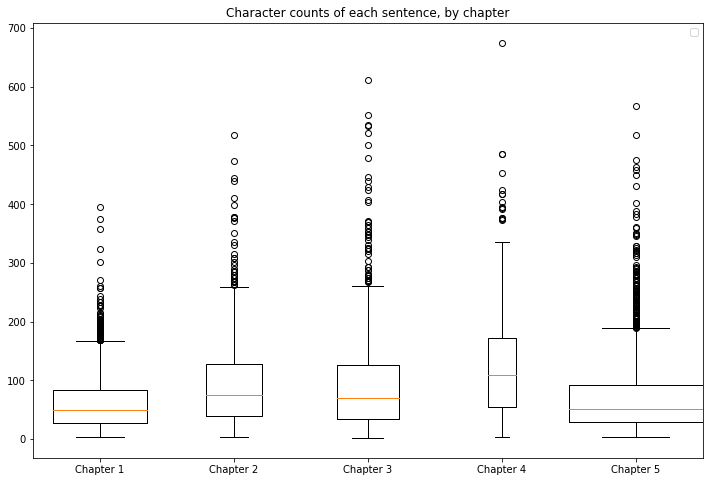

In [78]:
#Box and whisker plots
#Widths of boxes are lengths of chapters in proportion to Chapter 5.
box_widths = [df1['char_count'].shape[0] / df5['char_count'].shape[0],
 df2['char_count'].shape[0] / df5['char_count'].shape[0],
 df3['char_count'].shape[0] / df5['char_count'].shape[0],
 df4['char_count'].shape[0] / df5['char_count'].shape[0],
 df5['char_count'].shape[0] / df5['char_count'].shape[0]
]
#Labels for box and whisker plots
box_labels = ['Chapter 1', 'Chapter 2', 'Chapter 3', 'Chapter 4', 'Chapter 5']

#First box and whisker plot
#Chapter 4 has the longest sentences overall.
#Widths of boxes are lengths of chapters in proportion to Chapter 5.

fig = plt.figure(figsize = (12, 8))
plt.boxplot([df1['char_count'],
             df2['char_count'],
             df3['char_count'],
             df4['char_count'],
             df5['char_count']
            ], 
            labels = box_labels,
            widths = box_widths
           )
plt.legend()
plt.title('Character counts of each sentence, by chapter')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Mean token length for each sentence, by chapter')

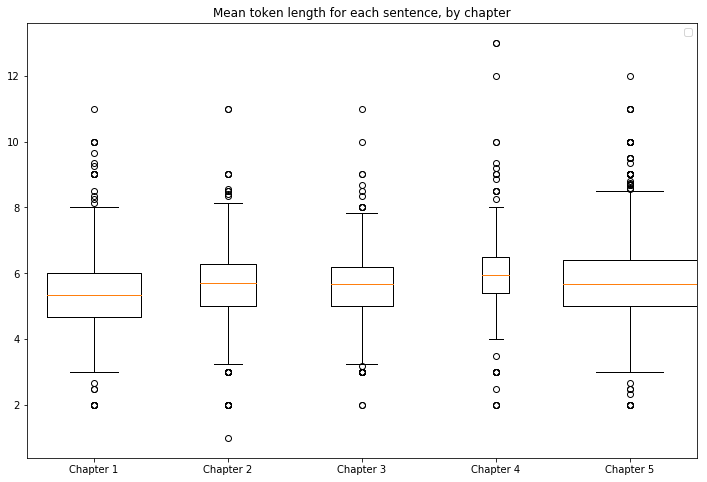

In [79]:
fig = plt.figure(figsize = (12, 8))
plt.boxplot([df1['mean_token_len'],
             df2['mean_token_len'],
             df3['mean_token_len'],
             df4['mean_token_len'],
             df5['mean_token_len']
            ], 
            labels = box_labels,
            widths = box_widths)
plt.legend()
plt.title('Mean token length for each sentence, by chapter')

Text(0.5, 1.0, 'Token count of each sentence, by chapter')

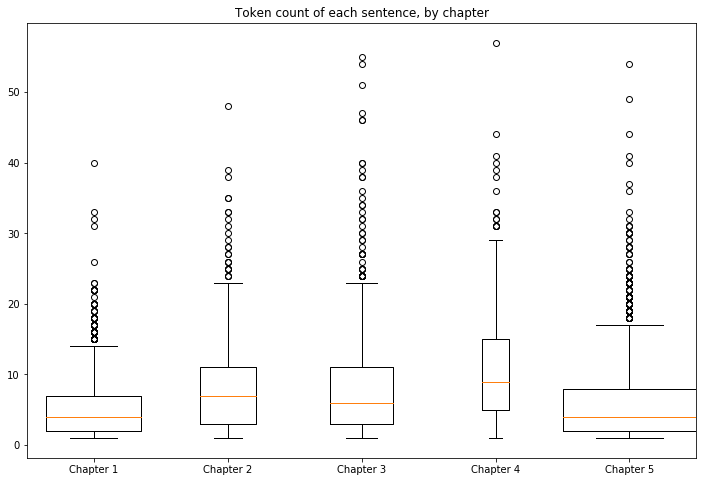

In [80]:
fig = plt.figure(figsize = (12, 8))
plt.boxplot([df1['token_count'],
             df2['token_count'],
             df3['token_count'],
             df4['token_count'],
             df5['token_count']
            ], 
            labels = box_labels,
            widths = box_widths)
plt.title('Token count of each sentence, by chapter')

In [ ]:
#Observations from box plots: Chapter 4 has longer character counts of its sentences
#and longer token counts (lengths of its words)

### Attempting some PCA to simplify mean vectors and maybe visualize?


In [117]:
df1.head()

,sentence,char_count,tokens,mean_token_len,token_count,vectors,mean_vector,label
0,Once upon a time and a very good time it was t...,143,"[upon, time, good, time, moocow, coming, along...",4.833333,12,"[[0.14861, -0.31427, -0.37246, -0.26593, -0.32...","[0.16427054, 0.12741734, -0.063235335, -0.1478...",1
1,met a nicens little boy named baby tuckoo....\n\n,47,"[met, nicens, little, boy, named, baby, tuckoo...",4.500000,8,"[[0.17151, 0.2361, -0.091475, -0.12491, 0.0446...","[-0.030713636, 0.13436475, -0.25785273, -0.021...",1
2,His father told him that story: his father loo...,96,"[father, told, story, father, looked, glass, h...",5.125000,8,"[[0.07836, 0.24624, -0.13153, 0.25374, 0.21725...","[-0.1338875, -0.10129124, -0.16580924, 0.22228...",1
3,He was baby tuckoo.,19,"[baby, tuckoo]",5.000000,2,"[[-0.1445, 0.32683, -0.62883, 0.18326, 0.27117...","[-0.07225, 0.163415, -0.314415, 0.09163, 0.135...",1
4,The moocow came down the road where Betty Byrn...,82,"[moocow, came, road, betty, byrne, lived, sold...",4.777778,9,"[[-0.0090117, 0.010151, 0.67677, -0.46424, -0....","[0.07056996, 0.28936455, 0.14651866, -0.130147...",1


In [85]:
pca = PCA()

In [135]:
matrix = np.matrix(df1.at[4, 'mean_vector']).getT()

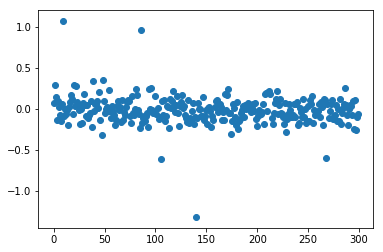

In [136]:
plt.scatter(range(300), matrix.getA())

In [137]:
transformed = pca.fit_transform(matrix)

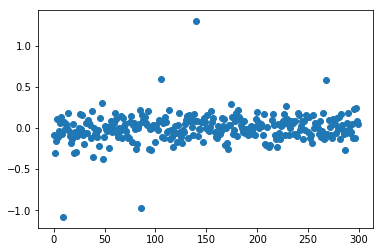

In [138]:
plt.scatter(range(300), transformed)

In [139]:
pca.explained_variance_ratio_

array([1.], dtype=float32)

In [140]:
np.cumsum(pca.explained_variance_ratio_)

array([1.], dtype=float32)

In [143]:
pca.mean_

array([-0.01491807], dtype=float32)

In [144]:
pca.get_covariance()

array([[0.02976144]], dtype=float32)

In [145]:
pca.components_

array([[-1.]], dtype=float32)

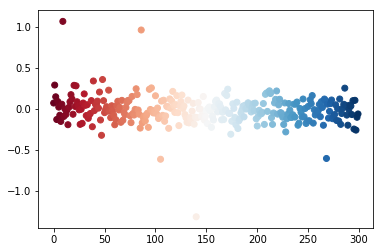

In [141]:
plt.scatter(range(300), matrix.getA(), c=sns.color_palette('RdBu', n_colors=300))

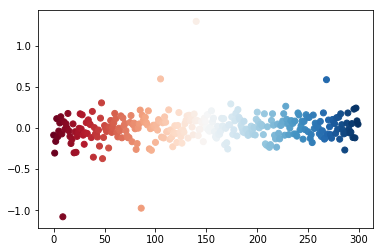

In [142]:
plt.scatter(range(300), transformed, c=sns.color_palette('RdBu', n_colors=300))

In [147]:
df1.shape[0], df2.shape[0], df3.shape[0], df4.shape[0], df5.shape[0]

(1457, 858, 960, 422, 2058)

In [11]:
df = df1[['mean_vector', 'label']].append([df2[['mean_vector', 'label']], 
                                           df3[['mean_vector', 'label']],
                                           df4[['mean_vector', 'label']],
                                           df5[['mean_vector', 'label']]
                                          ], ignore_index = True)

#Make each scalar in the 300-long vector into a column for the features
for i in np.arange(0, 300):
    df[str(i + 1)] = [v[i] for v in df['mean_vector'].values]

    #Separate features and target
features = df.drop(['mean_vector', 'label'], axis = 1, inplace = False)
target = df['label']

In [12]:
#From PCA analysis in scikit learn lab in Learn
#Try without normalizing too?
X = StandardScaler().fit_transform(features)

In [193]:
#If not normalizing
X = features

In [13]:
#From PCA analysis in scikit learn lab in Learn
pca = PCA(n_components = 3)
principalComponents = pca.fit_transform(X)

#From PCA analysis in scikit learn lab in Learn
# Create a new dataset fro principal components 
df_pca = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2', 'PC3'])
result_df = pd.concat([df_pca, target], axis = 1)

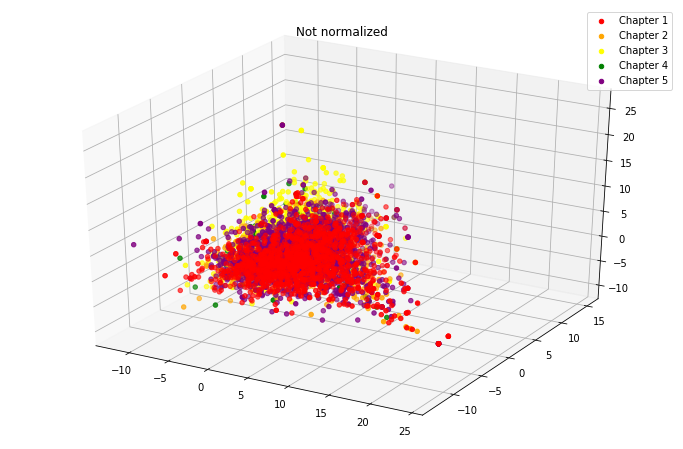

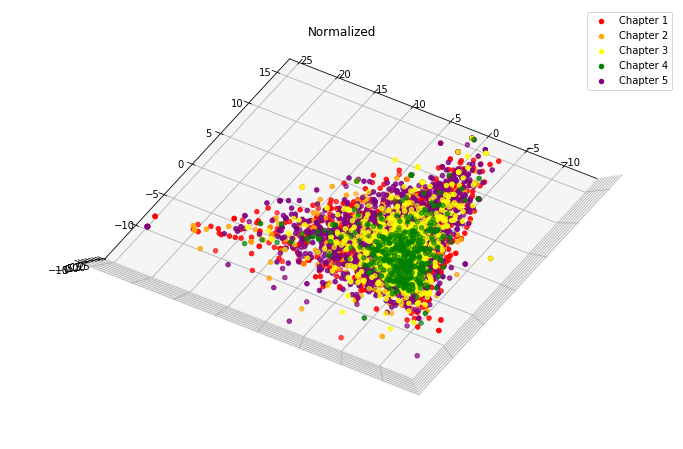

In [27]:
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111, projection='3d', azim = 60, elev = -90)

labels = [1, 2, 3, 4, 5]
colors = ['red', 'orange', 'yellow', 'green', 'purple']

for label, color in zip(labels, colors):
#    ch2_pca = result_df['label'] == label
    pca = result_df[result_df['label'] == label]
    ax.scatter(xs = pca['PC1'], ys = pca['PC2'], zs = pca['PC3'],
          c = color, label = ('Chapter ' + str(label)))

plt.legend()
plt.title('Normalized')
plt.show()

### Looking at individual plots after spotting a green cluster at azim 60 elev -90

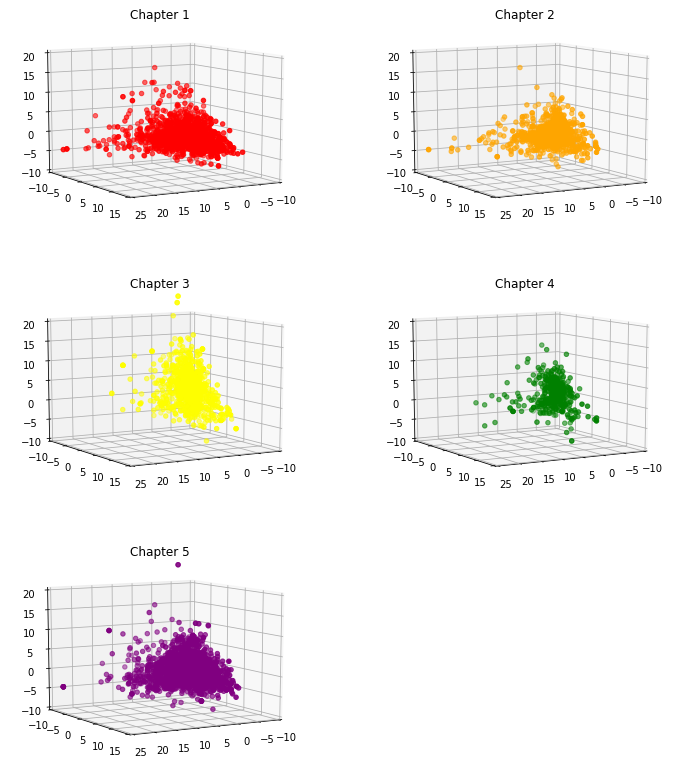

In [52]:
fig = plt.figure(figsize = (12, 14))
#ax = fig.add_subplot(111, projection='3d')
labels = [1, 2, 3, 4, 5]
colors = ['red', 'orange', 'yellow', 'green', 'purple']

for i, label, color in zip(range(1,6), labels, colors):
#    ch2_pca = result_df['label'] == label
    pca = result_df[result_df['label'] == label]
    ax = fig.add_subplot(3,2, i, projection='3d', azim = 60, elev = 10)
    plt.xlim(-10, 25)
    plt.ylim(-10, 15)
    ax.set_zlim(-10, 20)
    ax.scatter(xs = pca['PC1'], ys = pca['PC2'], zs = pca['PC3'],
          c = color, label = ('Chapter ' + str(label)))
    plt.title('Chapter ' + str(label))

plt.show()

### Try with PCA = 2?

### Trying same thing with just individual vectorized tokens

In [53]:
def stop_word(word):
    '''
    For just one word not a list.
    '''
    stop_list = stopwords.words('english')
    stop_list += list(string.punctuation)
    #stop_list += list(punctsh)
    stop_list += ['could', 'like', 'one', 'said', 'would', '\'s', '\'ll']
    
    if word.lower() not in stop_list:
        return word.lower()
        
def build_by_words_df(text, label):
    '''
    Calls a function to build each column in a df.
    Parameters:
    words (spacy.tokens.doc.Doc)
    Returns:
    df (pd.DataFrame)
    '''
   
    #List of tokens, stop words removed
    token = list(set([stop_word(word_tokenize(w.text)[0]) for w in text if w.is_alpha]))
    #Drop NaNs
    token_notna = [t for t in token if t]
    #Get list of vectors
    vector = [nlp.vocab[t].vector for t in token_notna]
    
    #Instantiate new df
    df = pd.DataFrame()
    #Build df columns from above lists
    df['token'] = token_notna
    df['vector'] = vector
    df['label'] = label
    
    return df

In [59]:
ch1_byword = build_by_words_df(ch1, 1)
ch2_byword = build_by_words_df(ch2, 2)
ch3_byword = build_by_words_df(ch3, 3)
ch4_byword = build_by_words_df(ch4, 4)
ch5_byword = build_by_words_df(ch5, 5)

In [119]:
#Get all empty vectors for a column 
#Might be worth replotting later without all these empties
print(ch1_byword[[np.all((row == zeros)) for row in ch1_byword['vector']]].shape[0])
print(ch2_byword[[np.all((row == zeros)) for row in ch2_byword['vector']]].shape[0])
print(ch3_byword[[np.all((row == zeros)) for row in ch3_byword['vector']]].shape[0])
print(ch4_byword[[np.all((row == zeros)) for row in ch4_byword['vector']]].shape[0])
print(ch5_byword[[np.all((row == zeros)) for row in ch5_byword['vector']]].shape[0])

237

In [116]:
ch1_byword.shape[0], ch2_byword.shape[0], ch3_byword.shape[0], ch4_byword.shape[0], ch5_byword.shape[0]

(2224, 3040, 3031, 2282, 4466)

In [216]:
byword = ch1_byword[['token', 'vector', 'label']].append([ch2_byword[['token', 'vector', 'label']],
                                                 ch3_byword[['token', 'vector', 'label']],
                                                 ch4_byword[['token', 'vector', 'label']],
                                                 ch5_byword[['token', 'vector', 'label']]
                                                ])

In [183]:
#Make each scalar in the 300-long vector into a column for the features
for i in np.arange(0, 300):
    byword[str(i + 1)] = [v[i] for v in byword['vector'].values]

    #Separate features and target
byword_features = byword.drop(['token', 'vector', 'label'], axis = 1, inplace = False)
byword_target = byword['label']

In [156]:
#From PCA analysis in scikit learn lab in Learn
#Try without normalizing too?
byword_X = StandardScaler().fit_transform(byword_features)

In [184]:
#If not normalizing
byword_X = byword_features

In [185]:
#From PCA analysis in scikit learn lab in Learn
pca = PCA(n_components = 3)
byword_principalComponents = pca.fit_transform(byword_X)

byword_pca_df = pd.DataFrame(data = byword_principalComponents, columns = ['PC1', 'PC2', 'PC3'])

#From PCA analysis in scikit learn lab in Learn
# Create a new dataset fro principal components 
#FOr some reason pd.concat doesn't work with this one
byword_result = copy.deepcopy(byword_pca_df)

byword_result['label'] = byword_target.values

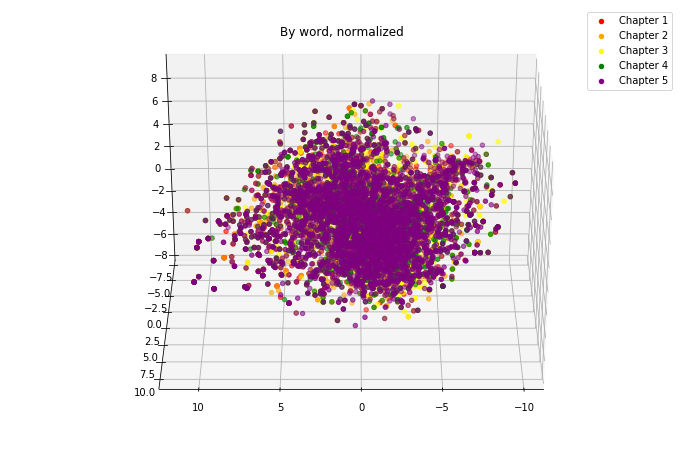

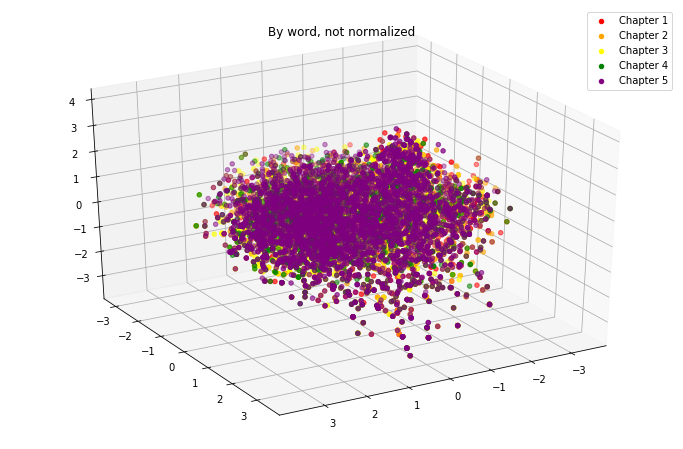

In [200]:
#Show all chapters together
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111, projection='3d', azim = 60, elev = 30)

labels = [1, 2, 3, 4, 5]
colors = ['red', 'orange', 'yellow', 'green', 'purple']

for label, color in zip(labels, colors):
#    ch2_pca = result_df['label'] == label
    pca = byword_result[byword_result['label'] == label]
    ax.scatter(xs = pca['PC1'], ys = pca['PC2'], zs = pca['PC3'],
          c = color, label = ('Chapter ' + str(label)))

plt.legend()
plt.title('By word, not normalized')
plt.show()

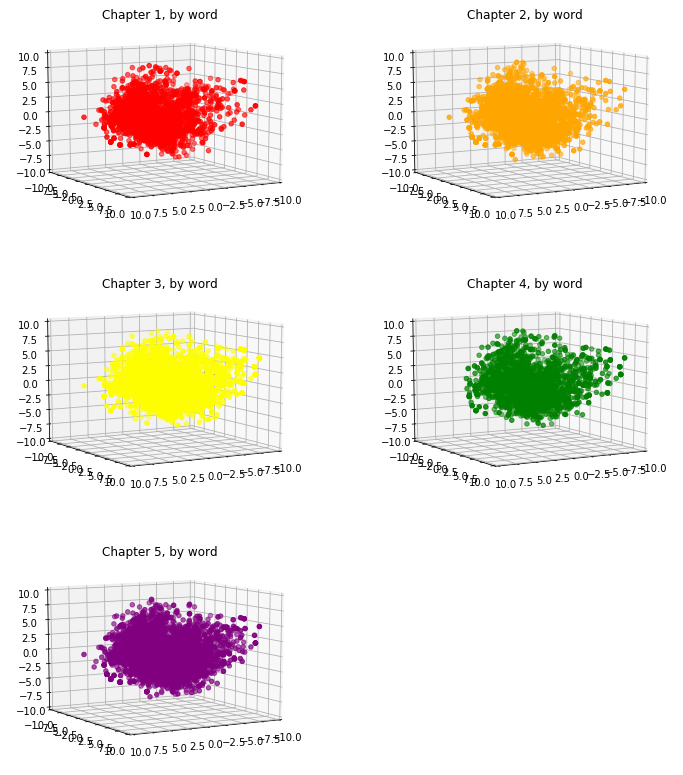

In [181]:
#Show each chapter as its own plot
fig = plt.figure(figsize = (12, 14))
#ax = fig.add_subplot(111, projection='3d')
labels = [1, 2, 3, 4, 5]
colors = ['red', 'orange', 'yellow', 'green', 'purple']

for i, label, color in zip(range(1,6), labels, colors):
#    ch2_pca = result_df['label'] == label
    pca = byword_result[byword_result['label'] == label]
    ax = fig.add_subplot(3,2, i, projection='3d', azim = 60, elev = 10)
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    ax.set_zlim(-10, 10)
    ax.scatter(xs = pca['PC1'], ys = pca['PC2'], zs = pca['PC3'],
          c = color, label = ('Chapter ' + str(label)))
    plt.title('Chapter ' + str(label) + ', by word')

plt.show()

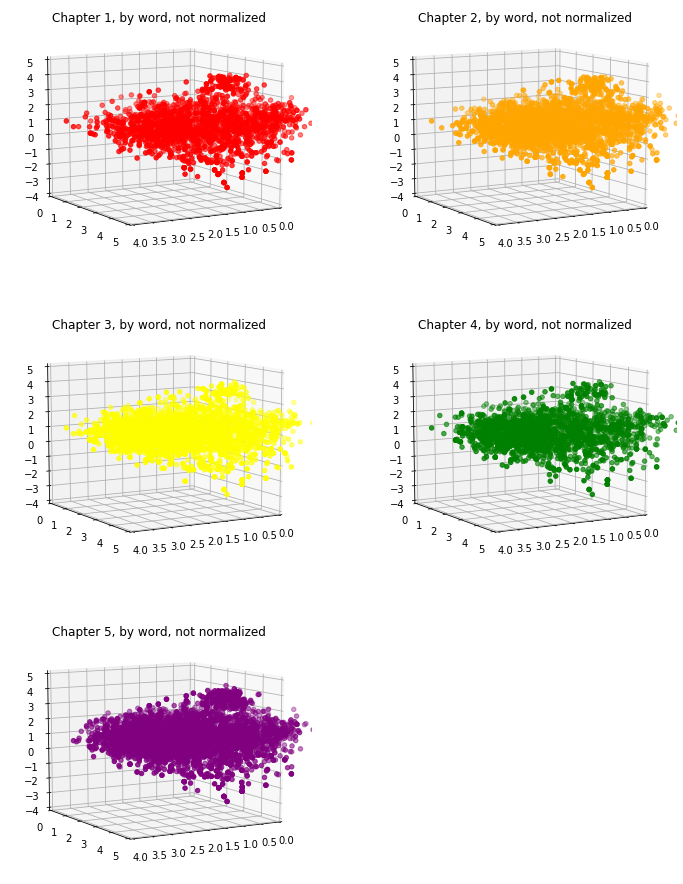

In [207]:
#Show each chapter as its own plot
fig = plt.figure(figsize = (12, 16))
#ax = fig.add_subplot(111, projection='3d')
labels = [1, 2, 3, 4, 5]
colors = ['red', 'orange', 'yellow', 'green', 'purple']

for i, label, color in zip(range(1,6), labels, colors):
#    ch2_pca = result_df['label'] == label
    pca = byword_result[byword_result['label'] == label]
    ax = fig.add_subplot(3,2, i, projection='3d', azim = 60, elev = 10)
    plt.xlim(0, 4)
    plt.ylim(0, 5)
    ax.set_zlim(-4, 5)
    ax.scatter(xs = pca['PC1'], ys = pca['PC2'], zs = pca['PC3'],
          c = color, label = ('Chapter ' + str(label)))
    plt.title('Chapter ' + str(label) + ', by word, not normalized')

plt.show()

### Will unique words look like anything when plotted?

In [217]:
#Compare to ch1
two345 = byword[byword['label'] != 1]
#Compare to ch2
one345 = byword[byword['label'] != 2]
# #Compare to ch3
one245 = byword[byword['label'] != 3]
# #Compare to ch4
one235 = byword[byword['label'] != 4]
# #Compare to ch5
one234 = byword[byword['label'] != 5]

In [ ]:
two345[]

In [218]:
two345.head()

,token,vector,label
0,every,"[-0.068741, 0.31892, 0.098401, 0.19436, 0.2526...",2
1,gave,"[-0.19102, 0.29065, -0.016854, 0.22152, -0.282...",2
2,visit,"[0.44834, 0.079046, -0.57362, 0.41331, 0.58243...",2
3,swooning,"[-0.41701, -0.82298, 0.11431, 0.29533, -0.1387...",2
4,insistent,"[-0.18414, -0.10469, -0.29933, 0.05228, 0.0743...",2


In [223]:
#Tokens unique to chapter 1
len([token for token in ch1_byword['token'].values if token not in two345['token'].values])

678

# RESUME HERE. Get unique tokens for each chapter and redo PCA and plotting above.

### Train test split

# Insight workflow
### Data cleaning:
- tokenize
- remove non-alphanumeric
- to lower case
- combine words with similar spellings
- lemmatize?

### Words into numbers
- bag words [0 0 0 0 0 1 0 0 ]